# VAE Discriminator for DeepFake Detection
This notebook contains the implementation of a Variational Autoencoder (VAE) with a discriminator for detecting DeepFake images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Set random seed for reproducibility

In [2]:
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Define dataset paths

In [3]:
REAL_DIR = "wiki"
FAKE_DIRS = ["inpainting", "insight", "text2img"]

## Dataset class

In [4]:
class DeepFakeDataset(Dataset):
    def __init__(self, real_dir, fake_dirs, split='train', transform=None, val_split=0.15, test_split=0.15, max_images_per_class=None):
        """
        Dataset for loading DeepFake Face images.

        Args:
            real_dir: Directory containing real images
            fake_dirs: List of directories containing fake images
            split: One of 'train', 'val', or 'test'
            transform: Image transformations
            val_split: Proportion of data for validation
            test_split: Proportion of data for testing
            max_images_per_class: Maximum number of images to use per class (real/fake)
        """
        self.transform = transform

        # Get all image paths with limit
        real_images = self._get_image_paths(real_dir, label=0, max_images=max_images_per_class)  # 0 = real

        fake_images = []
        # If we have multiple fake directories, distribute the limit among them
        fake_dir_limit = None
        if max_images_per_class is not None:
            fake_dir_limit = max_images_per_class // len(fake_dirs)

        for fake_dir in fake_dirs:
            fake_images.extend(self._get_image_paths(fake_dir, label=1, max_images=fake_dir_limit))  # 1 = fake

        # Combine and shuffle
        all_images = real_images + fake_images
        np.random.shuffle(all_images)

        # Print dataset stats
        print(f"Loaded {len(real_images)} real images and {len(fake_images)} fake images")

        # Split into train, val, test
        total_size = len(all_images)
        test_size = int(total_size * test_split)
        val_size = int(total_size * val_split)
        train_size = total_size - test_size - val_size

        if split == 'train':
            self.images = all_images[:train_size]
        elif split == 'val':
            self.images = all_images[train_size:train_size+val_size]
        elif split == 'test':
            self.images = all_images[train_size+val_size:]
        else:
            raise ValueError("Split must be one of 'train', 'val', or 'test'")

        print(f"{split} dataset size: {len(self.images)}")
    
    def _get_image_paths(self, directory, label, max_images=None):
        """Get all image paths with labels from directory with an optional limit"""
        image_paths = []

        # Recursively walk through directory structure
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append((os.path.join(root, file), label))
                    # Check if we've reached the limit
                    if max_images is not None and len(image_paths) >= max_images:
                        return image_paths

        return image_paths
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]

        # Load and convert image
        try:
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black placeholder image
            placeholder = torch.zeros((3, 224, 224))
            return placeholder, label

## Variational Autoencoder for DeepFake Detection

In [42]:
class VAEDiscriminator(nn.Module):
    def __init__(self, latent_dim=128, num_classes=2):
        super(VAEDiscriminator, self).__init__()
        
        # Encoder (using pretrained ResNet features)
        resnet = models.resnet34(pretrained=True)
        modules = list(resnet.children())[:-1]  # Remove the last FC layer
        self.encoder_backbone = nn.Sequential(*modules)
        
        # Define the latent space parameters (mean and log variance)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_var = nn.Linear(512, latent_dim)
        
        # Classifier head from latent space
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
        
        # Decoder network
        self.decoder_input = nn.Linear(latent_dim, 512)
        
        # Transpose convolutions for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 2x2
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.BatchNorm2d(8),
            nn.ReLU(),

            nn.ConvTranspose2d(8, 4, kernel_size=4, stride=2, padding=1),  # 128x128
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.ConvTranspose2d(4, 3, kernel_size=4, stride=2, padding=1),  # 224x224
            nn.Tanh()  # Output in range [-1, 1]
        )

    
    def encode(self, x):
        # Extract features
        x = self.encoder_backbone(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Get mean and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        # Map from latent space to feature space
        x = self.decoder_input(z)
        # Reshape to feature map
        x = x.view(-1, 512, 1, 1)
        # Decode
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        # Encode
        mu, log_var = self.encode(x)
        
        # Sample from latent space
        z = self.reparameterize(mu, log_var)
        
        # Decode 
        x_recon = self.decode(z)
        
        # Classify
        predictions = self.classifier(z)
        
        # Return reconstruction, mean, log_var, and classification
        return x_recon, mu, log_var, predictions
    
    def classify(self, x):
        # For inference, just use the encoder and classifier
        mu, _ = self.encode(x)
        return self.classifier(mu)

## Combined loss function for VAE discriminator

In [43]:
class VAEDiscriminatorLoss(nn.Module):
    def __init__(self, reconstruction_weight=1.0, kl_weight=0.1):
        super(VAEDiscriminatorLoss, self).__init__()
        self.reconstruction_weight = reconstruction_weight
        self.kl_weight = kl_weight
        self.classification_loss = nn.CrossEntropyLoss()
    
    def forward(self, x_recon, x, mu, log_var, predictions, labels):
        # Reconstruction loss
        recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / x.size(0)
        
        # Classification loss
        clf_loss = self.classification_loss(predictions, labels)
        
        # Total loss
        total_loss = self.reconstruction_weight * recon_loss + self.kl_weight * kl_loss + clf_loss
        
        return total_loss, recon_loss, kl_loss, clf_loss

## Training function

In [44]:
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_vae_discriminator(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    best_val_accuracy = 0.0
    history = {
        'train_loss': [], 'train_recon_loss': [], 'train_kl_loss': [], 'train_clf_loss': [], 'train_acc': [],
        'val_loss': [], 'val_recon_loss': [], 'val_kl_loss': [], 'val_clf_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_recon_loss = 0.0
        running_kl_loss = 0.0
        running_clf_loss = 0.0
        all_preds = []
        all_labels = []
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            x_recon, mu, log_var, predictions = model(images)
            
            # Calculate loss
            loss, recon_loss, kl_loss, clf_loss = criterion(x_recon, images, mu, log_var, predictions, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            running_recon_loss += recon_loss.item() * images.size(0)
            running_kl_loss += kl_loss.item() * images.size(0)
            running_clf_loss += clf_loss.item() * images.size(0)
            
            _, preds = torch.max(predictions, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_recon_loss = running_recon_loss / len(train_loader.dataset)
        epoch_kl_loss = running_kl_loss / len(train_loader.dataset)
        epoch_clf_loss = running_clf_loss / len(train_loader.dataset)
        epoch_acc = accuracy_score(all_labels, all_preds)
        
        # Store training metrics
        history['train_loss'].append(epoch_loss)
        history['train_recon_loss'].append(epoch_recon_loss)
        history['train_kl_loss'].append(epoch_kl_loss)
        history['train_clf_loss'].append(epoch_clf_loss)
        history['train_acc'].append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_recon_loss = 0.0
        val_running_kl_loss = 0.0
        val_running_clf_loss = 0.0
        val_all_preds = []
        val_all_labels = []
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                x_recon, mu, log_var, predictions = model(images)
                
                # Calculate loss
                loss, recon_loss, kl_loss, clf_loss = criterion(x_recon, images, mu, log_var, predictions, labels)
                
                # Statistics
                val_running_loss += loss.item() * images.size(0)
                val_running_recon_loss += recon_loss.item() * images.size(0)
                val_running_kl_loss += kl_loss.item() * images.size(0)
                val_running_clf_loss += clf_loss.item() * images.size(0)
                
                _, preds = torch.max(predictions, 1)
                val_all_preds.extend(preds.cpu().numpy())
                val_all_labels.extend(labels.cpu().numpy())
        
        # Calculate validation metrics
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_recon_loss = val_running_recon_loss / len(val_loader.dataset)
        val_epoch_kl_loss = val_running_kl_loss / len(val_loader.dataset)
        val_epoch_clf_loss = val_running_clf_loss / len(val_loader.dataset)
        val_epoch_acc = accuracy_score(val_all_labels, val_all_preds)
        
        # Store validation metrics
        history['val_loss'].append(val_epoch_loss)
        history['val_recon_loss'].append(val_epoch_recon_loss)
        history['val_kl_loss'].append(val_epoch_kl_loss)
        history['val_clf_loss'].append(val_epoch_clf_loss)
        history['val_acc'].append(val_epoch_acc)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {epoch_loss:.4f}, Recon: {epoch_recon_loss:.4f}, KL: {epoch_kl_loss:.4f}, "
              f"CLF: {epoch_clf_loss:.4f}, Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_epoch_loss:.4f}, Recon: {val_epoch_recon_loss:.4f}, KL: {val_epoch_kl_loss:.4f}, "
              f"CLF: {val_epoch_clf_loss:.4f}, Acc: {val_epoch_acc:.4f}")
        
        # Save best model
        if val_epoch_acc > best_val_accuracy:
            best_val_accuracy = val_epoch_acc
            torch.save(model.state_dict(), 'best_vae_discriminator.pth')
            print(f"Saved new best model with validation accuracy: {best_val_accuracy:.4f}")
    
    # Load best model
    model.load_state_dict(torch.load('best_vae_discriminator.pth'))
    return model, history


## Evaluation function


In [45]:
def evaluate_vae_discriminator(model, test_loader, criterion):
    model.to(device)
    model.eval()
    
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_clf_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            x_recon, mu, log_var, predictions = model(images)
            
            # Calculate loss
            loss, recon_loss, kl_loss, clf_loss = criterion(x_recon, images, mu, log_var, predictions, labels)
            
            # Statistics
            running_loss += loss.item() * images.size(0)
            running_recon_loss += recon_loss.item() * images.size(0)
            running_kl_loss += kl_loss.item() * images.size(0)
            running_clf_loss += clf_loss.item() * images.size(0)
            
            probs = F.softmax(predictions, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of fake class
            _, preds = torch.max(predictions, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(test_loader.dataset)
    test_recon_loss = running_recon_loss / len(test_loader.dataset)
    test_kl_loss = running_kl_loss / len(test_loader.dataset)
    test_clf_loss = running_clf_loss / len(test_loader.dataset)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    print(f"Test Loss: {test_loss:.4f}, Recon: {test_recon_loss:.4f}, KL: {test_kl_loss:.4f}, CLF: {test_clf_loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Return evaluation metrics
    metrics = {
        'loss': test_loss,
        'recon_loss': test_recon_loss,
        'kl_loss': test_kl_loss,
        'clf_loss': test_clf_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }
    
    return metrics

## Visualize reconstructions and their classification


In [46]:
def visualize_reconstructions(model, dataloader, num_images=8):
    model.to(device)
    model.eval()
    
    # Get a batch of images
    images, labels = next(iter(dataloader))
    images = images.to(device)
    labels = labels.cpu().numpy()
    
    # Get reconstructions
    with torch.no_grad():
        recons, _, _, predictions = model(images)
        probs = F.softmax(predictions, dim=1)
        pred_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        fake_probs = probs[:, 1].cpu().numpy()
    
    # Convert images from tensor to numpy
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    recons = recons.cpu().permute(0, 2, 3, 1).numpy()
    
    # Denormalize images
    images = np.clip((images * 0.5) + 0.5, 0, 1)
    recons = np.clip((recons * 0.5) + 0.5, 0, 1)
    
    # Plot reconstructions
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        # Original image
        axes[0, i].imshow(images[i])
        true_label = "Real" if labels[i] == 0 else "Fake"
        axes[0, i].set_title(f"True: {true_label}")
        axes[0, i].axis('off')
        
        # Reconstructed image
        axes[1, i].imshow(recons[i])
        pred_label = "Real" if pred_labels[i] == 0 else "Fake"
        axes[1, i].set_title(f"Pred: {pred_label} ({fake_probs[i]:.2f})")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('reconstructions.png')
    plt.show()
    
    return fig

## Visualize latent space

In [47]:
def visualize_latent_space(model, dataloader, n_samples=1000):
    model.to(device)
    model.eval()
    
    all_labels = []
    all_latent = []
    
    # Collect latent representations
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i * dataloader.batch_size >= n_samples:
                break
                
            images = images.to(device)
            mu, _ = model.encode(images)
            
            all_latent.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    
    # Concatenate batches
    all_latent = np.concatenate(all_latent, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Reduce dimensionality for visualization
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(all_latent)
    
    # Plot latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=all_labels, 
                          cmap='coolwarm', alpha=0.7, s=20)
    plt.colorbar(scatter, label='Class (0=Real, 1=Fake)')
    plt.title('Latent Space (PCA)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True, alpha=0.3)
    plt.savefig('latent_space.png')
    plt.show()
    
    return plt.gcf()

## Plot training history

In [48]:
def plot_training_history(history):
    # Plot losses
    plt.figure(figsize=(20, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(history['train_recon_loss'], label='Train')
    plt.plot(history['val_recon_loss'], label='Validation')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 3)
    plt.plot(history['train_kl_loss'], label='Train')
    plt.plot(history['val_kl_loss'], label='Validation')
    plt.title('KL Divergence Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(history['train_clf_loss'], label='Train')
    plt.plot(history['val_clf_loss'], label='Validation')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_losses.png')
    plt.show()
    
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('training_accuracy.png')
    plt.show()

## Generate new fake images from the latent space

In [49]:
def generate_fake_images(model, num_images=16, random_seed=42):
    model.to(device)
    model.eval()
    
    # Set random seed for reproducibility
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    
    # Sample from the latent space
    z = torch.randn(num_images, model.fc_mu.out_features).to(device)
    
    # Generate images
    with torch.no_grad():
        generated_images = model.decode(z)
    
    # Convert images from tensor to numpy
    generated_images = generated_images.cpu().permute(0, 2, 3, 1).numpy()
    
    # Denormalize images
    generated_images = np.clip((generated_images * 0.5) + 0.5, 0, 1)
    
    # Plot generated images
    fig, axes = plt.subplots(int(np.sqrt(num_images)), int(np.sqrt(num_images)), 
                             figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(num_images):
        axes[i].imshow(generated_images[i])
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('generated_images.png')
    plt.show()
    
    return generated_images

## Plot confusion matrix

In [50]:
def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

## Main function to run the experiment

Creating datasets...
Loaded 500 real images and 498 fake images
train dataset size: 700
Loaded 500 real images and 498 fake images
val dataset size: 149
Loaded 500 real images and 498 fake images
test dataset size: 149
Creating model...
Training model...


Epoch 1/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.12it/s]


Epoch 1/20:
Train Loss: 71537.9375, Recon: 71535.8824, KL: 130.5410, CLF: 0.7498, Acc: 0.4657
Val Loss: 69605.4359, Recon: 69600.1586, KL: 451.6465, CLF: 0.7602, Acc: 0.5973
Saved new best model with validation accuracy: 0.5973


Epoch 2/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 2/20:
Train Loss: 66659.6285, Recon: 66657.4073, KL: 148.0952, CLF: 0.7398, Acc: 0.5043
Val Loss: 64507.8668, Recon: 64505.3512, KL: 178.0425, CLF: 0.7361, Acc: 0.4228


Epoch 3/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.15it/s]


Epoch 3/20:
Train Loss: 62309.6559, Recon: 62307.4458, KL: 148.3086, CLF: 0.7274, Acc: 0.5071
Val Loss: 57589.4471, Recon: 57586.9264, KL: 177.5285, CLF: 0.7457, Acc: 0.4430


Epoch 4/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.12it/s]


Epoch 4/20:
Train Loss: 58223.2771, Recon: 58220.8730, KL: 168.9869, CLF: 0.7141, Acc: 0.5357
Val Loss: 53131.8447, Recon: 53128.8352, KL: 229.2944, CLF: 0.7169, Acc: 0.4765


Epoch 5/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.09it/s]


Epoch 5/20:
Train Loss: 55490.4842, Recon: 55488.1784, KL: 157.4184, CLF: 0.7316, Acc: 0.5000
Val Loss: 49754.3723, Recon: 49751.6187, KL: 205.5813, CLF: 0.6981, Acc: 0.5369


Epoch 6/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]


Epoch 6/20:
Train Loss: 52268.0924, Recon: 52265.7654, KL: 162.7444, CLF: 0.6997, Acc: 0.5186
Val Loss: 46637.8309, Recon: 46634.9787, KL: 215.0658, CLF: 0.7015, Acc: 0.4966


Epoch 7/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.04s/it]


Epoch 7/20:
Train Loss: 49468.4227, Recon: 49465.8130, KL: 189.5298, CLF: 0.7145, Acc: 0.5071
Val Loss: 43728.0653, Recon: 43724.9177, KL: 242.8159, CLF: 0.7196, Acc: 0.4631


Epoch 8/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.16s/it]


Epoch 8/20:
Train Loss: 47165.0288, Recon: 47162.2597, KL: 206.7938, CLF: 0.7012, Acc: 0.5129
Val Loss: 41401.5439, Recon: 41398.3132, KL: 254.0643, CLF: 0.6902, Acc: 0.5168


Epoch 9/20 - Validation: 100%|█████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.02s/it]


Epoch 9/20:
Train Loss: 45156.0128, Recon: 45153.0711, KL: 224.5679, CLF: 0.6961, Acc: 0.5214
Val Loss: 39720.4793, Recon: 39716.8441, KL: 292.4350, CLF: 0.7107, Acc: 0.4631


Epoch 10/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:19<00:00,  1.03s/it]


Epoch 10/20:
Train Loss: 44073.0391, Recon: 44069.9272, KL: 242.0695, CLF: 0.6913, Acc: 0.5343
Val Loss: 38422.6675, Recon: 38418.9368, KL: 302.9519, CLF: 0.7022, Acc: 0.5034


Epoch 11/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:17<00:00,  1.08it/s]


Epoch 11/20:
Train Loss: 42769.6153, Recon: 42766.4148, KL: 249.8081, CLF: 0.7021, Acc: 0.5000
Val Loss: 39495.5705, Recon: 39492.3607, KL: 251.4729, CLF: 0.6951, Acc: 0.5168


Epoch 12/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.03it/s]


Epoch 12/20:
Train Loss: 41308.6358, Recon: 41305.4016, KL: 254.9143, CLF: 0.6848, Acc: 0.5500
Val Loss: 35982.5620, Recon: 35978.9887, KL: 287.6437, CLF: 0.6970, Acc: 0.4899


Epoch 13/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.13s/it]


Epoch 13/20:
Train Loss: 41082.5922, Recon: 41079.3178, KL: 258.3052, CLF: 0.6917, Acc: 0.5143
Val Loss: 34835.0798, Recon: 34831.1855, KL: 320.0411, CLF: 0.6938, Acc: 0.5168


Epoch 14/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.13it/s]


Epoch 14/20:
Train Loss: 39977.3422, Recon: 39973.9701, KL: 269.2609, CLF: 0.6791, Acc: 0.5500
Val Loss: 34154.8565, Recon: 34151.1669, KL: 299.3761, CLF: 0.6957, Acc: 0.5101


Epoch 15/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.00it/s]


Epoch 15/20:
Train Loss: 39124.8781, Recon: 39121.3634, KL: 283.5949, CLF: 0.6786, Acc: 0.5443
Val Loss: 34137.6324, Recon: 34133.8447, KL: 308.7195, CLF: 0.7007, Acc: 0.4497


Epoch 16/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.13it/s]


Epoch 16/20:
Train Loss: 38295.1024, Recon: 38291.5356, KL: 289.4948, CLF: 0.6720, Acc: 0.5800
Val Loss: 33052.9309, Recon: 33048.8209, KL: 340.8121, CLF: 0.7021, Acc: 0.5034


Epoch 17/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.15it/s]


Epoch 17/20:
Train Loss: 37941.1519, Recon: 37937.4859, KL: 298.4125, CLF: 0.6820, Acc: 0.5429
Val Loss: 32953.4210, Recon: 32949.2206, KL: 350.8439, CLF: 0.6923, Acc: 0.5034


Epoch 18/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.18s/it]


Epoch 18/20:
Train Loss: 37901.2584, Recon: 37897.4978, KL: 308.3667, CLF: 0.6768, Acc: 0.5471
Val Loss: 31912.6920, Recon: 31908.4225, KL: 357.8194, CLF: 0.6917, Acc: 0.5034


Epoch 19/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:23<00:00,  1.22s/it]


Epoch 19/20:
Train Loss: 37249.7431, Recon: 37245.8906, KL: 317.9059, CLF: 0.6736, Acc: 0.5629
Val Loss: 32301.5663, Recon: 32297.2707, KL: 360.0530, CLF: 0.6955, Acc: 0.4698


Epoch 20/20 - Validation: 100%|████████████████████████████████████████████████████████| 19/19 [00:21<00:00,  1.14s/it]


Epoch 20/20:
Train Loss: 36474.1748, Recon: 36470.2515, KL: 324.9448, CLF: 0.6739, Acc: 0.5657
Val Loss: 31480.8734, Recon: 31476.3780, KL: 380.0559, CLF: 0.6949, Acc: 0.5101
Plotting training history...


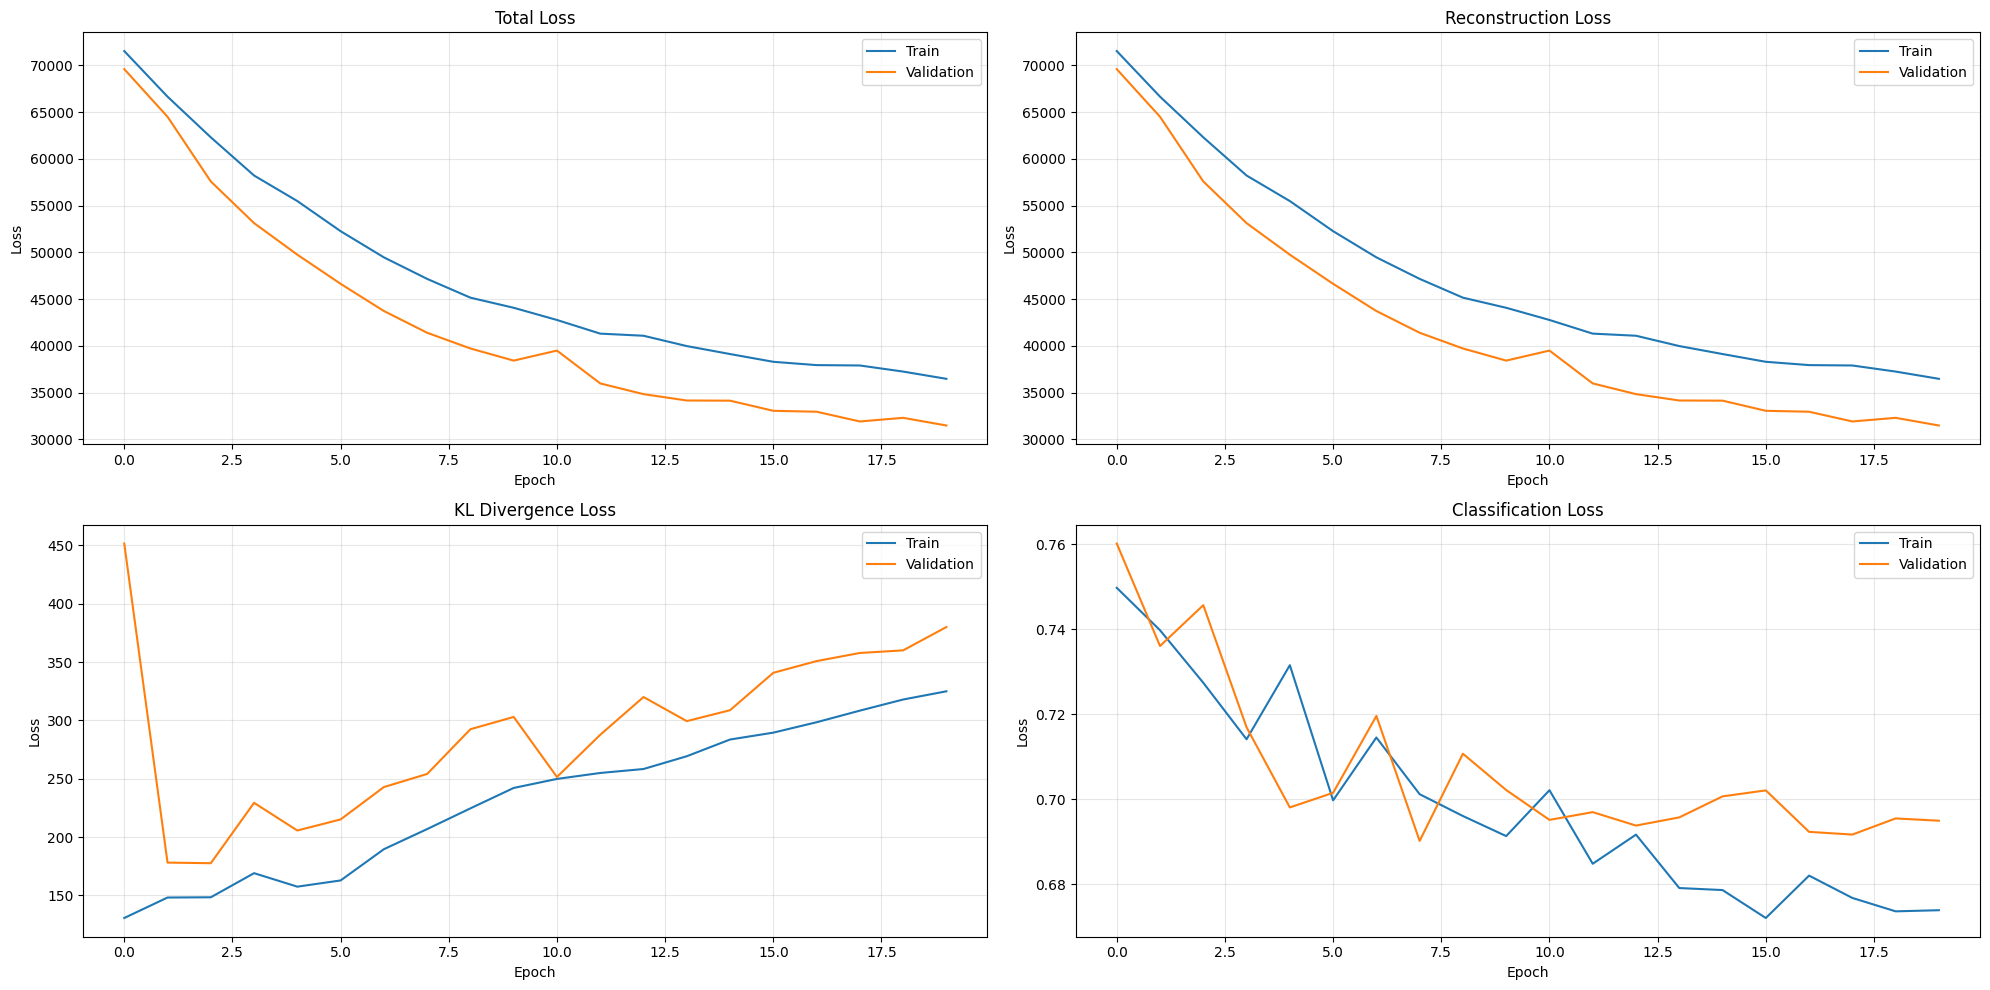

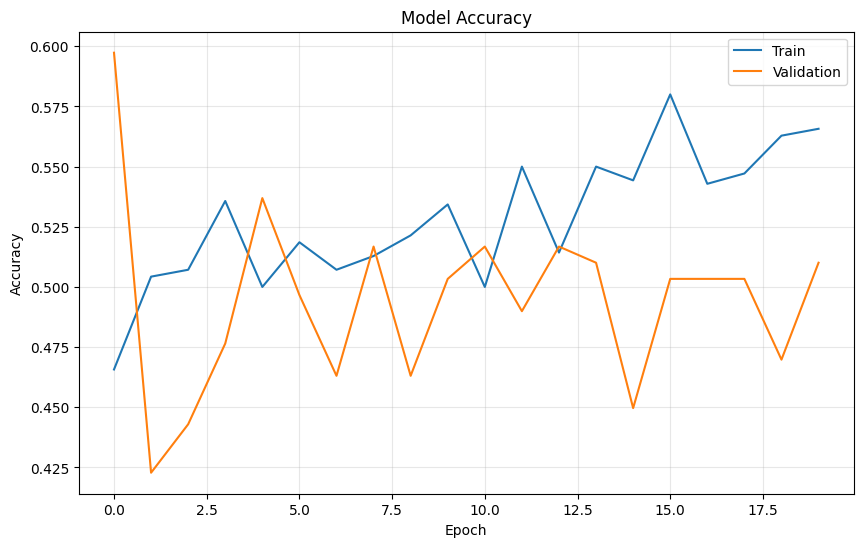

In [52]:
def main():
    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    
    # Create datasets and dataloaders
    print("Creating datasets...")
    train_dataset = DeepFakeDataset(
        real_dir=REAL_DIR,
        fake_dirs=FAKE_DIRS,
        split='train',
        transform=transform,
        max_images_per_class=500  # Use 10,000 images per class
    )
    
    val_dataset = DeepFakeDataset(
        real_dir=REAL_DIR,
        fake_dirs=FAKE_DIRS,
        split='val',
        transform=transform,
        max_images_per_class=500
    )
    
    test_dataset = DeepFakeDataset(
        real_dir=REAL_DIR,
        fake_dirs=FAKE_DIRS,
        split='test',
        transform=transform,
        max_images_per_class=500
    )
    
    batch_size = 8
    num_workers = 4
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=False
    )
    
    # Create model
    print("Creating model...")
    model = VAEDiscriminator(latent_dim=128)
    
    # Create loss function
    # Start with a higher weight on reconstruction to ensure good image quality
    # Then gradually increase KL weight during training via a callback if needed
    criterion = VAEDiscriminatorLoss(reconstruction_weight=1.0, kl_weight=0.01)
    
    # Create optimizer and learning rate scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3, verbose=True
    )
    
    # Train model
    print("Training model...")
    model, history = train_vae_discriminator(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=20
    )
    
    # Plot training history
    print("Plotting training history...")
    plot_training_history(history)
    
    # Evaluate

if __name__ == '__main__':
    # On Windows, this prevents hanging or crashing of DataLoader
    torch.multiprocessing.freeze_support()
    main()